# Лабораторная 1. Фильтр Блума

In [2]:
import hashlib
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

## 1. Реализация фильтра Блума

Фильтр Блума — это вероятностная структура данных, которая позволяет проверять, принадлежит ли элемент множеству, с возможностью ложноположительных срабатываний. Мы создадим класс BloomFilter, который будет включать собственные хеш-функции.

In [1]:
class BloomFilter:
    def __init__(self, size, num_hashes):
        self.size = size
        self.num_hashes = num_hashes
        self.bit_array = [0] * size

    def _hash(self, item):
        return int(hashlib.md5(item.encode()).hexdigest(), 16) % self.size

    def add(self, item):
        for i in range(self.num_hashes):
            index = (self._hash(item) + i) % self.size
            self.bit_array[index] = 1

    def check(self, item):
        for i in range(self.num_hashes):
            index = (self._hash(item) + i) % self.size
            if self.bit_array[index] == 0:
                return False
        return True

Пример работы

In [3]:
bloom = BloomFilter(size=1000, num_hashes=5)
bloom.add("example")
print(bloom.check("example"))
print(bloom.check("not_in_set"))

True
False


## 2. Определение процента ложноположительных срабатываний

Процент ложноположительных срабатываний можно оценить, добавив несколько элементов в фильтр и проверив, сколько из них возвращают True для элементов, которые не были добавлены.

In [5]:
def false_positive_rate(bloom_filter, test_items, num_tests):
    false_positives = 0
    for item in test_items:
        if bloom_filter.check(item):
            false_positives += 1
    return false_positives / num_tests

In [15]:
bloom = BloomFilter(size=1000, num_hashes=5)

add_size = 10
test_size = 50

for i in range(add_size):
    bloom.add("not_in_set" + str(i))

test_items = ["not_in_set" + str(i) for i in range(test_size)]
procent = false_positive_rate(bloom, test_items, test_size)

result = round((procent - add_size / test_size) * 100, 3)
f"{result} %"

'2.0 %'

## 3. Оценка зависимости ложноположительных срабатываний

Для оценки зависимости ложноположительных срабатываний относительно размерности массива ( m ) и числа хеш-функций ( k ), можно построить таблицу и графики.

In [16]:
def evaluate_false_positive_rates(max_size, max_hashes):
    results = []
    for size in range(100, max_size, 100):
        for num_hashes in range(1, max_hashes + 1):
            bloom = BloomFilter(size, num_hashes)
            for i in range(50):
                bloom.add(f"item_{i}")
            false_rate = false_positive_rate(bloom, test_items, len(test_items))
            results.append((size, num_hashes, false_rate))
    return results


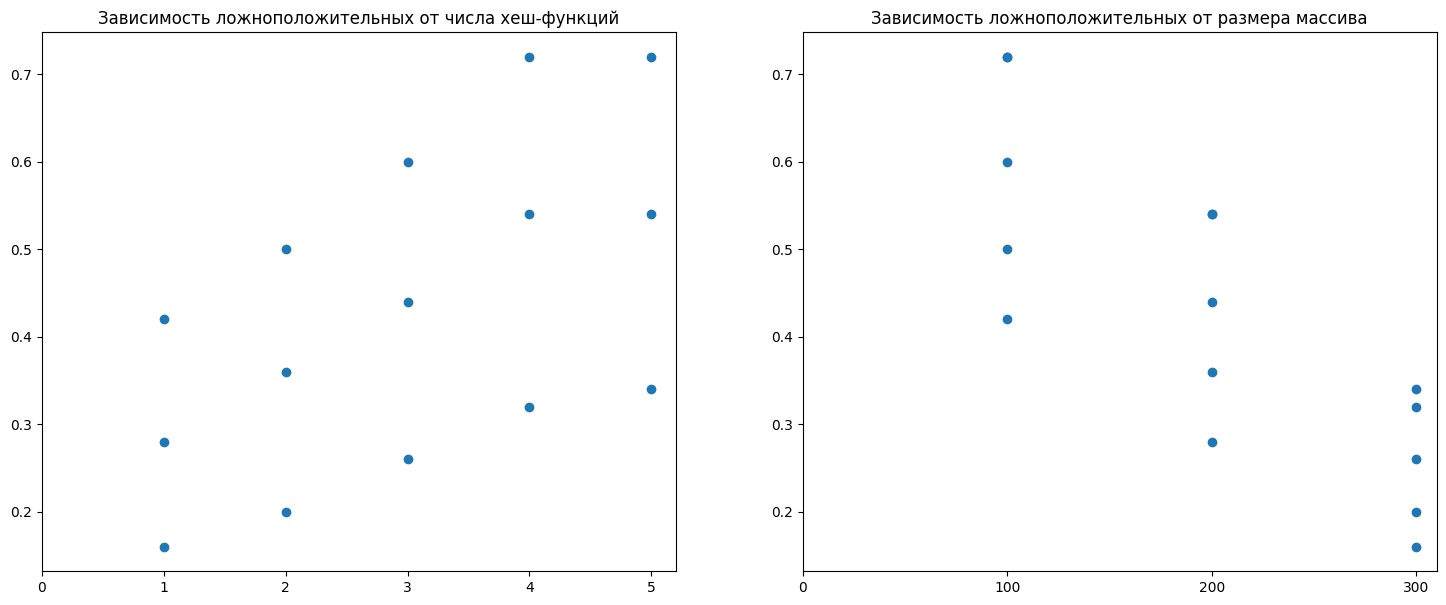

In [17]:
size = 400
num_hash = 5
results = np.array(evaluate_false_positive_rates(size, num_hash))

plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
plt.title("Зависимость ложноположительных от числа хеш-функций")
plt.scatter(results[:, 1], results[:, 2])
plt.xticks(range(num_hash + 1))
plt.subplot(1, 2, 2)
plt.title("Зависимость ложноположительных от размера массива")
plt.scatter(results[:, 0], results[:, 2])
plt.xticks(range(0, size, 100))
plt.show()

## 4. Многофакторный дисперсионный анализ

Для многофакторного дисперсионного анализа можно использовать библиотеку scipy или statsmodels.

In [ ]:
def perform_anova(data):
    df = pd.DataFrame(data, columns=['size', 'num_hashes', 'false_positive_rate'])
    model = ols('false_positive_rate ~ C(size) + C(num_hashes)', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    return anova_table

anova_results = perform_anova(results)
print(anova_results)

                 sum_sq   df          F    PR(>F)
C(size)        0.204577  1.0  31.266223  0.005019
C(num_hashes)  0.031051  4.0   1.186423  0.436207
Residual       0.026172  4.0        NaN       NaN


## 5. Пересечение и объединение фильтров Блума

Для реализации пересечения и объединения фильтров Блума можно создать методы для этих операций:

In [9]:
def union(bloom1, bloom2):
    if bloom1.size != bloom2.size:
        raise ValueError("Bloom filters must be of the same size")
    new_bloom = BloomFilter(bloom1.size, bloom1.num_hashes)
    new_bloom.bit_array = [b1 | b2 for b1, b2 in zip(bloom1.bit_array, bloom2.bit_array)]
    return new_bloom

def intersection(bloom1, bloom2):
    if bloom1.size != bloom2.size:
        raise ValueError("Bloom filters must be of the same size")
    new_bloom = BloomFilter(bloom1.size, bloom1.num_hashes)
    new_bloom.bit_array = [b1 & b2 for b1, b2 in zip(bloom1.bit_array, bloom2.bit_array)]
    return new_bloom